<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries,-functions-and-data" data-toc-modified-id="Load-libraries,-functions-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries, functions and data</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></div>

Third iteration: using data augmentation to balance the number of images in normal (0) and pneumonia (1).

## Load libraries, functions and data

In [1]:
%config Completer.use_jedi = False

In [2]:
from keras import layers
from keras import models
from keras.models import load_model
import cv2
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix

In [3]:
import sys

sys.path.append('../src')

from helpers import load_augment_images, shuffle_arrays

## Data augmentation

In [6]:
img_dir = "../data/chest_xray/chest_xray/"
dir_train = img_dir + "train/"
dir_test = img_dir + "test/"

In [7]:
train_images, train_labels = load_augment_images(dir_train, augment_label="NORMAL")

100% |########################################################################|
100% |########################################################################|


In [8]:
train_images.shape

(7898, 250, 250, 1)

In [9]:
train_labels.shape

(7898,)

In [10]:
test_images, test_labels = load_augment_images(dir_test)

100% |########################################################################|
100% |########################################################################|


In [11]:
test_images.shape

(624, 250, 250, 1)

In [12]:
test_labels.shape

(624,)

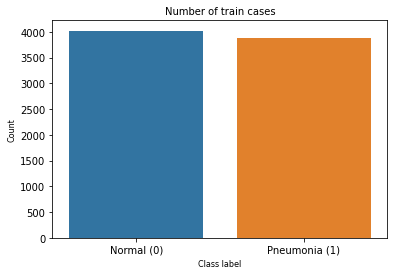

In [13]:
normal_cases = 0
pneumonia_cases = 0

for i in range(train_labels.shape[0]):
    if train_labels[i] == 0:
        normal_cases += 1
    elif train_labels[i] == 1:
        pneumonia_cases += 1

cases = [normal_cases, pneumonia_cases]

sns.barplot(x = ["Normal (0)", "Pneumonia (1)"], y = cases)
plt.title(f'Number of train cases', fontsize=10)
plt.xlabel('Class label', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.show;

We now have approximately the same number of 0s and 1s

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

In [16]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
checkpoint_filepath = 'model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
# shuffling the data so that validation is not just done for images with label = 1

train_images_shuff, train_labels_shuff = shuffle_arrays(train_images, train_labels)

In [19]:
model.fit(train_images_shuff, train_labels_shuff, epochs=10, batch_size=128, validation_split=0.1, callbacks=model_checkpoint_callback)

Epoch 1/10
56/56 [==============================] - 447s 8s/step - loss: 13.6078 - accuracy: 0.6711 - val_loss: 0.2616 - val_accuracy: 0.9076
Epoch 2/10
56/56 [==============================] - 450s 8s/step - loss: 0.2524 - accuracy: 0.8892 - val_loss: 0.1140 - val_accuracy: 0.9608
Epoch 3/10
56/56 [==============================] - 442s 8s/step - loss: 0.1713 - accuracy: 0.9474 - val_loss: 0.0955 - val_accuracy: 0.9582
Epoch 4/10
56/56 [==============================] - 458s 8s/step - loss: 0.9037 - accuracy: 0.9587 - val_loss: 0.0724 - val_accuracy: 0.9747
Epoch 5/10
56/56 [==============================] - 458s 8s/step - loss: 0.0792 - accuracy: 0.9701 - val_loss: 0.0554 - val_accuracy: 0.9797
Epoch 6/10
56/56 [==============================] - 460s 8s/step - loss: 0.2287 - accuracy: 0.9603 - val_loss: 0.0693 - val_accuracy: 0.9734
Epoch 7/10
56/56 [==============================] - 454s 8s/step - loss: 0.0662 - accuracy: 0.9757 - val_loss: 0.0446 - val_accuracy: 0.9848
Epoch 8/10
5

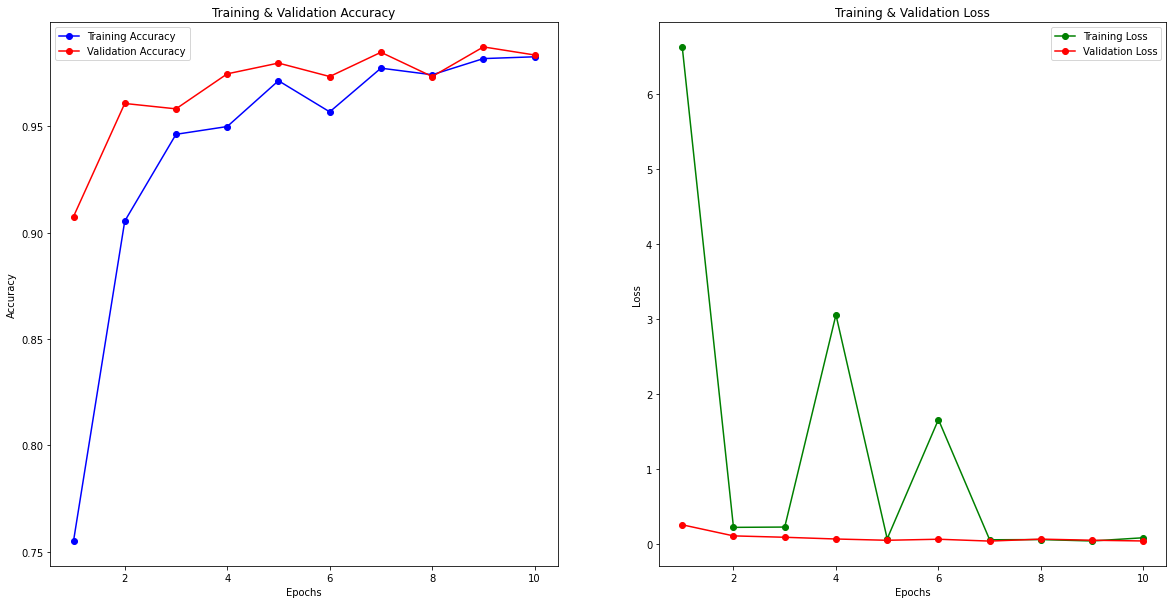

In [20]:
# plot evolution of accuracy and loss

epochs = [i for i in range(1,11)]
fig , ax = plt.subplots(1,2)
train_acc = model.history.history['accuracy']
train_loss = model.history.history['loss']
val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [33]:
# save model for future use

model.save('my_model_it3.h5')

In [21]:
prediction = (model.predict(test_images) > 0.5).astype("int32")

In [22]:
df = pd.DataFrame()
df["is_pneumonia"] = test_labels
df["predict_pneumonia"] = prediction

In [23]:
cm = pd.crosstab(
    df.is_pneumonia,
    df.predict_pneumonia
)
cm

predict_pneumonia,0,1
is_pneumonia,,
0,118,116
1,3,387


In [24]:
test_loss, test_score = model.evaluate(test_images, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 [==============================] - 11s 265ms/step - loss: 0.8582 - accuracy: 0.8093
Loss on test set:  0.8582460284233093
Accuracy on test set:  0.8092948794364929


In [25]:
precision = cm[1][1]/(cm[1][0] + cm[1][1])
recall = cm[1][1]/(cm[0][1] + cm[1][1])

print(f"Recall of the model is {round(recall, 2)}")
print(f"Precision of the model is {round(precision, 2)}")

Recall of the model is 0.99
Precision of the model is 0.77


In [36]:
prediction[0][0]

1